# Example of data filtering, using utility functions in wdf

*author: Elena Cuoco*

Sometime you may need to high pass, low pass or filter your data, while you are in a loop with SeqView of data. 
We will show how you can do this with SeqView structures, using utility functions which rely on scipy signal library

In [1]:
import time
import os
from pytsa.tsa import *
from pytsa.tsa import SeqView_double_t as SV
from wdf.config.Parameters import *
import numpy as np 
 
import logging, sys
logging.disable(sys.maxsize)
logging.basicConfig(level=logging.DEBUG)
new_json_config_file = True    # set to True if you want to create new Configuration
 
new_json_config_file = True    # set to True if you want to create new Configuration
if new_json_config_file==True:
    configuration = {
      "file": "./data/test.gwf",
      "channel": "H1:GWOSC-4KHZ_R1_STRAIN", 
      "len":1.0,
      "gps":1167559100,
      "outdir": "./",
      "dir":"./", 
      "ARorder": 2000,
      "learn": 200,
      "preWhite":4
    }

    filejson = os.path.join(os.getcwd(),"InputParameters.json")
    file_json = open(filejson, "w+")
    json.dump(configuration, file_json)
    file_json.close()
logging.info("read parameters from JSON file")

par = Parameters()
filejson = "InputParameters.json"
try:
    par.load(filejson)
except IOError:
    logging.error("Cannot find resource file " + filejson)
    quit()
    
strInfo = FrameIChannel(par.file, par.channel, 1.0, par.gps)
Info = SV()
strInfo.GetData(Info)
par.sampling = int(1.0 / Info.GetSampling())
logging.info("channel= %s at sampling frequency= %s" %(par.channel, par.sampling))
 

 

## Butterworth Filter

Often it is useful to cut off low frequency in your data, because the noise is too high and you are not looking for signal in that region of frequency.
We can do using a Butterworth filter from scipy library. It is advised that you make a design study offline to decide better the order of your filter.

In [2]:
from wdf.utility.Filters import *
from wdf.utility.HighPassFilter import *
frequency=20
sampling=par.sampling
order=5
filtertype='high'
bf=Butterworth(frequency, sampling, order, filtertype)
hp=HighPassFilter(frequency, sampling,order) 

### Pre-heating of the filter

We use some chunck of data to pre-heating the filtering procedure and avoiding the filter tail.

In [3]:

data = SV()
dataf = SV()
datafl = SV()
streaming = FrameIChannel(par.file, par.channel, par.len, par.gps)

###---filter preheating---###
for i in range(1):
    streaming.GetData(data)
    dataf=bf.ProcessSeq(data)
    datafl=hp.Process(data)
 

### Filtering

In [4]:
#filtering
streaming.GetData(data)
dataf=bf.ProcessSeq(data)
datafl=hp.Process(data)
 
 

## Plot: raw and filtered data

### Time-domain

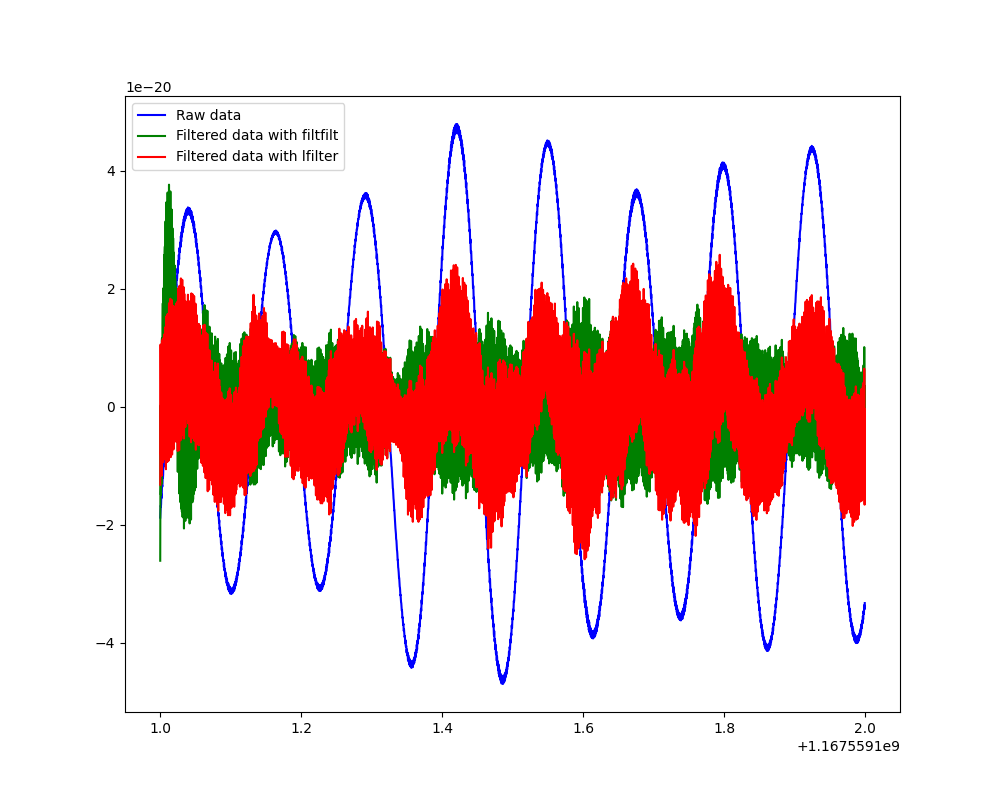

In [5]:
import matplotlib.pylab as plt
import numpy as np
import logging
%matplotlib widget 
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)
x=np.zeros(data.GetSize())
y=np.zeros(data.GetSize())
yf=np.zeros(dataf.GetSize())
yfl=np.zeros(dataf.GetSize())


for i in range(data.GetSize()):
    x[i]=data.GetX(i)
    y[i]=data.GetY(0,i)
    yf[i]=dataf.GetY(0,i)
    yfl[i]=datafl.GetY(0,i)
plt.figure(figsize=(10,8))
 
plt.plot(x, y/20,'b', label='Raw data')
plt.plot(x, yf, 'g', label='Filtered data with filtfilt')
plt.plot(x, yfl, 'r',label='Filtered data with lfilter')

plt.legend()
plt.show()
    


### Frequency domain (PSD)

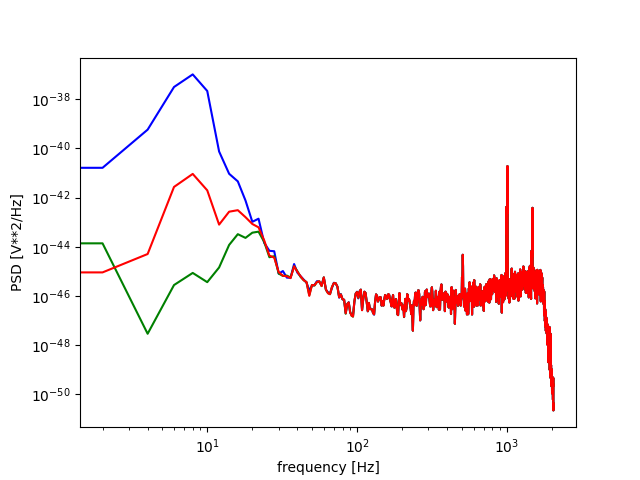

In [6]:
from scipy import signal
f, Pxx_den = signal.welch(y, par.sampling, nperseg=2048)
f, Pxx_denW = signal.welch(yf, par.sampling, nperseg=2048)
f, Pxx_denHP= signal.welch(yfl, par.sampling, nperseg=2048)
fig, ax = plt.subplots()
ax.loglog(f, Pxx_den,'b')
ax.loglog(f, Pxx_denW,'g') 
ax.loglog(f, Pxx_denHP,'r') 
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()